In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm
from IPython.display import FileLink

Почитать про аугментиции
https://www.programmersought.com/article/10767080578/

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# распаковываем архив
with zipfile.ZipFile('../input/platesv2/plates.zip','r') as z:
    z.extractall('.')
    
print(os.listdir('./plates/'))

data_root = './plates'
print(os.listdir(data_root))

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip
['train', '.DS_Store', 'test']
['train', '.DS_Store', 'test']


In [3]:
train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

os.remove(os.path.join(data_root, 'train/cleaned', '.DS_Store'))
os.remove(os.path.join(data_root, 'train/dirty', '.DS_Store'))

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 20/20 [00:00<00:00, 3682.61it/s]


In [4]:
os.listdir('./val/dirty')

['0014.jpg', '0011.jpg', '0009.jpg', '0012.jpg']

In [5]:
def show_input(input_tensor, title=''):
    std = [0.229, 0.224, 0.225]
    mean = [0.485, 0.456, 0.406]
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image)
    plt.title(title)
    plt.show()
    plt.pause(0.001)

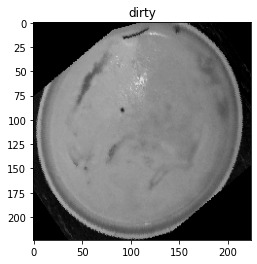

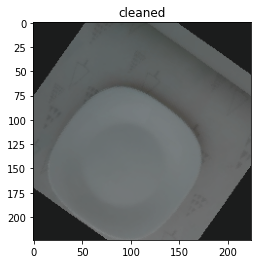

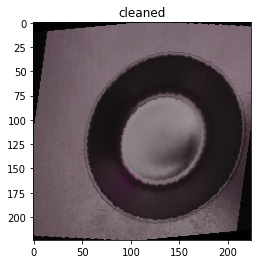

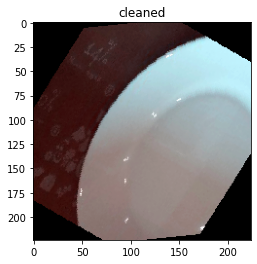

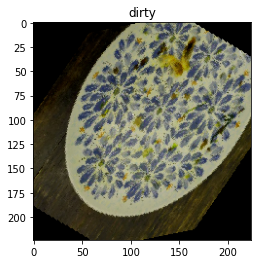

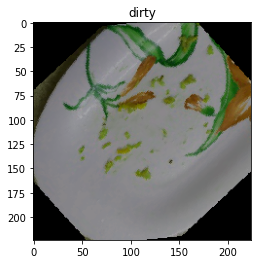

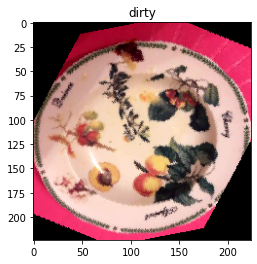

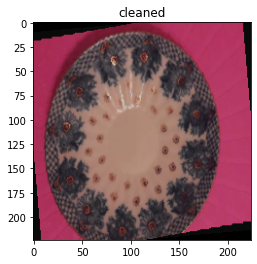

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.45, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4),
    transforms.ColorJitter(contrast=0.4),
    transforms.ColorJitter(saturation=0.4),
    transforms.ColorJitter(hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=0, shear=(0, 0, 0, 15)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()
        
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
          
        
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    axes[0].set(title='loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='val')
    axes[0].grid()
    axes[0].legend()
    axes[1].set(title='accuracy')
    axes[1].plot(train_acc, label='train')
    axes[1].plot(val_acc, label='val')
    axes[1].grid()
    axes[1].legend()
        
    plt.show()

    return model

In [8]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-3, momentum=0.85)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/149:


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

train Loss: 0.7859 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8758 Acc: 0.2500
Epoch 1/149:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.6817 Acc: 0.5312



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.9079 Acc: 0.3750
Epoch 2/149:



100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

train Loss: 0.7335 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 0.9411 Acc: 0.2500
Epoch 3/149:



100%|██████████| 4/4 [00:00<00:00,  6.77it/s]

train Loss: 0.6053 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

val Loss: 0.9515 Acc: 0.2500
Epoch 4/149:



100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

train Loss: 0.6251 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.9395 Acc: 0.2500
Epoch 5/149:



100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

train Loss: 0.5958 Acc: 0.5938



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.9808 Acc: 0.2500
Epoch 6/149:



100%|██████████| 4/4 [00:00<00:00,  6.89it/s]

train Loss: 0.5997 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.9245 Acc: 0.2500
Epoch 7/149:



100%|██████████| 4/4 [00:00<00:00,  4.50it/s]

train Loss: 0.5452 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.27it/s]

val Loss: 0.9158 Acc: 0.2500
Epoch 8/149:



100%|██████████| 4/4 [00:00<00:00,  4.60it/s]

train Loss: 0.5610 Acc: 0.6250



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

val Loss: 0.9076 Acc: 0.2500
Epoch 9/149:



100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

train Loss: 0.5291 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.8941 Acc: 0.2500
Epoch 10/149:



100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

train Loss: 0.4452 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.9255 Acc: 0.3750
Epoch 11/149:



100%|██████████| 4/4 [00:00<00:00,  6.57it/s]

train Loss: 0.5981 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8733 Acc: 0.3750
Epoch 12/149:



100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

train Loss: 0.3906 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8860 Acc: 0.3750
Epoch 13/149:



100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

train Loss: 0.4814 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.9349 Acc: 0.3750
Epoch 14/149:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 0.5005 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.8809 Acc: 0.3750
Epoch 15/149:



100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

train Loss: 0.5588 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.9262 Acc: 0.3750
Epoch 16/149:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.5055 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.8742 Acc: 0.3750
Epoch 17/149:



100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

train Loss: 0.4608 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.8619 Acc: 0.3750
Epoch 18/149:



100%|██████████| 4/4 [00:00<00:00,  6.49it/s]

train Loss: 0.3647 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8382 Acc: 0.3750
Epoch 19/149:



100%|██████████| 4/4 [00:00<00:00,  6.27it/s]

train Loss: 0.4377 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

val Loss: 0.8283 Acc: 0.3750
Epoch 20/149:



100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

train Loss: 0.3695 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.8297 Acc: 0.3750
Epoch 21/149:



100%|██████████| 4/4 [00:00<00:00,  6.48it/s]

train Loss: 0.3710 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8295 Acc: 0.3750
Epoch 22/149:



100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

train Loss: 0.4002 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8264 Acc: 0.3750
Epoch 23/149:



100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

train Loss: 0.4492 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8278 Acc: 0.3750
Epoch 24/149:



100%|██████████| 4/4 [00:00<00:00,  6.20it/s]

train Loss: 0.3853 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8553 Acc: 0.3750
Epoch 25/149:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

train Loss: 0.3901 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.8457 Acc: 0.3750
Epoch 26/149:



100%|██████████| 4/4 [00:00<00:00,  6.44it/s]

train Loss: 0.3597 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.8309 Acc: 0.3750
Epoch 27/149:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 0.3399 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.8428 Acc: 0.3750
Epoch 28/149:



100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

train Loss: 0.4349 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.8428 Acc: 0.3750
Epoch 29/149:



100%|██████████| 4/4 [00:00<00:00,  6.81it/s]

train Loss: 0.4255 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8187 Acc: 0.3750
Epoch 30/149:



100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

train Loss: 0.3564 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

val Loss: 0.8372 Acc: 0.3750
Epoch 31/149:



100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

train Loss: 0.4586 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

val Loss: 0.8441 Acc: 0.3750
Epoch 32/149:



100%|██████████| 4/4 [00:00<00:00,  6.71it/s]

train Loss: 0.3871 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8382 Acc: 0.3750
Epoch 33/149:



100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

train Loss: 0.4704 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 0.8289 Acc: 0.3750
Epoch 34/149:



100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

train Loss: 0.3960 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.8371 Acc: 0.3750
Epoch 35/149:



100%|██████████| 4/4 [00:00<00:00,  6.16it/s]

train Loss: 0.3422 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8261 Acc: 0.3750
Epoch 36/149:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3761 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.8374 Acc: 0.3750
Epoch 37/149:



100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

train Loss: 0.3388 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8409 Acc: 0.3750
Epoch 38/149:



100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

train Loss: 0.4148 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.8381 Acc: 0.3750
Epoch 39/149:



100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

train Loss: 0.4767 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.8390 Acc: 0.3750
Epoch 40/149:



100%|██████████| 4/4 [00:00<00:00,  5.95it/s]

train Loss: 0.3939 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

val Loss: 0.8284 Acc: 0.3750
Epoch 41/149:



100%|██████████| 4/4 [00:00<00:00,  4.21it/s]

train Loss: 0.3375 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8222 Acc: 0.3750
Epoch 42/149:



100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

train Loss: 0.3968 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.8203 Acc: 0.3750
Epoch 43/149:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.3869 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

val Loss: 0.8307 Acc: 0.3750
Epoch 44/149:



100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

train Loss: 0.3000 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

val Loss: 0.8443 Acc: 0.3750
Epoch 45/149:



100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

train Loss: 0.3135 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8362 Acc: 0.3750
Epoch 46/149:



100%|██████████| 4/4 [00:00<00:00,  6.37it/s]

train Loss: 0.3700 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.8401 Acc: 0.3750
Epoch 47/149:



100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

train Loss: 0.4471 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8156 Acc: 0.3750
Epoch 48/149:



100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

train Loss: 0.3274 Acc: 0.9688



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.8079 Acc: 0.3750
Epoch 49/149:



100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

train Loss: 0.3518 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8233 Acc: 0.3750
Epoch 50/149:



100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

train Loss: 0.3653 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.53it/s]

val Loss: 0.8312 Acc: 0.3750
Epoch 51/149:



100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

train Loss: 0.3970 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8230 Acc: 0.3750
Epoch 52/149:



100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

train Loss: 0.3561 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.8257 Acc: 0.3750
Epoch 53/149:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3739 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.8407 Acc: 0.3750
Epoch 54/149:



100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

train Loss: 0.3572 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.75it/s]

val Loss: 0.8560 Acc: 0.3750
Epoch 55/149:



100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

train Loss: 0.4339 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.8346 Acc: 0.3750
Epoch 56/149:



100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

train Loss: 0.4056 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8523 Acc: 0.3750
Epoch 57/149:



100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

train Loss: 0.4871 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.8397 Acc: 0.3750
Epoch 58/149:



100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

train Loss: 0.3885 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

val Loss: 0.8229 Acc: 0.3750
Epoch 59/149:



100%|██████████| 4/4 [00:00<00:00,  6.33it/s]

train Loss: 0.4273 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8420 Acc: 0.3750
Epoch 60/149:



100%|██████████| 4/4 [00:00<00:00,  6.55it/s]

train Loss: 0.3987 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8621 Acc: 0.3750
Epoch 61/149:



100%|██████████| 4/4 [00:00<00:00,  6.82it/s]

train Loss: 0.3856 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

val Loss: 0.8618 Acc: 0.3750
Epoch 62/149:



100%|██████████| 4/4 [00:00<00:00,  5.68it/s]

train Loss: 0.4237 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

val Loss: 0.8503 Acc: 0.3750
Epoch 63/149:



100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

train Loss: 0.4104 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8603 Acc: 0.3750
Epoch 64/149:



100%|██████████| 4/4 [00:00<00:00,  6.47it/s]

train Loss: 0.4315 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8728 Acc: 0.3750
Epoch 65/149:



100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

train Loss: 0.3907 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

val Loss: 0.8478 Acc: 0.3750
Epoch 66/149:



100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

train Loss: 0.3285 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 0.8390 Acc: 0.3750
Epoch 67/149:



100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

train Loss: 0.3751 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8647 Acc: 0.3750
Epoch 68/149:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.4102 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.8177 Acc: 0.3750
Epoch 69/149:



100%|██████████| 4/4 [00:00<00:00,  6.67it/s]

train Loss: 0.3817 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

val Loss: 0.8177 Acc: 0.3750
Epoch 70/149:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.3757 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8351 Acc: 0.3750
Epoch 71/149:



100%|██████████| 4/4 [00:00<00:00,  6.15it/s]

train Loss: 0.3290 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8344 Acc: 0.3750
Epoch 72/149:



100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

train Loss: 0.3805 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8186 Acc: 0.3750
Epoch 73/149:



100%|██████████| 4/4 [00:00<00:00,  6.28it/s]

train Loss: 0.4262 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8236 Acc: 0.3750
Epoch 74/149:



100%|██████████| 4/4 [00:01<00:00,  3.69it/s]

train Loss: 0.3636 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

val Loss: 0.8379 Acc: 0.3750
Epoch 75/149:



100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

train Loss: 0.3665 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

val Loss: 0.8360 Acc: 0.3750
Epoch 76/149:



100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

train Loss: 0.4477 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

val Loss: 0.8485 Acc: 0.3750
Epoch 77/149:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.3771 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.09it/s]

val Loss: 0.8404 Acc: 0.3750
Epoch 78/149:



100%|██████████| 4/4 [00:00<00:00,  6.31it/s]

train Loss: 0.3565 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8556 Acc: 0.3750
Epoch 79/149:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.3993 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8378 Acc: 0.3750
Epoch 80/149:



100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

train Loss: 0.3626 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8469 Acc: 0.3750
Epoch 81/149:



100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

train Loss: 0.5291 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.8490 Acc: 0.3750
Epoch 82/149:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.3149 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.8359 Acc: 0.3750
Epoch 83/149:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3742 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8513 Acc: 0.3750
Epoch 84/149:



100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

train Loss: 0.3659 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.8267 Acc: 0.3750
Epoch 85/149:



100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

train Loss: 0.4312 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8133 Acc: 0.3750
Epoch 86/149:



100%|██████████| 4/4 [00:00<00:00,  6.46it/s]

train Loss: 0.4662 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8141 Acc: 0.3750
Epoch 87/149:



100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

train Loss: 0.4010 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

val Loss: 0.8186 Acc: 0.3750
Epoch 88/149:



100%|██████████| 4/4 [00:00<00:00,  4.94it/s]

train Loss: 0.3530 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.8429 Acc: 0.3750
Epoch 89/149:



100%|██████████| 4/4 [00:00<00:00,  6.36it/s]

train Loss: 0.3565 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

val Loss: 0.8420 Acc: 0.3750
Epoch 90/149:



100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

train Loss: 0.3907 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8353 Acc: 0.3750
Epoch 91/149:



100%|██████████| 4/4 [00:00<00:00,  6.65it/s]

train Loss: 0.4197 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8493 Acc: 0.3750
Epoch 92/149:



100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

train Loss: 0.3539 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.8461 Acc: 0.3750
Epoch 93/149:



100%|██████████| 4/4 [00:00<00:00,  6.40it/s]

train Loss: 0.3228 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

val Loss: 0.8380 Acc: 0.3750
Epoch 94/149:



100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

train Loss: 0.3787 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

val Loss: 0.8260 Acc: 0.3750
Epoch 95/149:



100%|██████████| 4/4 [00:00<00:00,  6.43it/s]

train Loss: 0.4065 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.8485 Acc: 0.3750
Epoch 96/149:



100%|██████████| 4/4 [00:00<00:00,  6.61it/s]

train Loss: 0.4512 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8376 Acc: 0.3750
Epoch 97/149:



100%|██████████| 4/4 [00:00<00:00,  6.30it/s]

train Loss: 0.3885 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.8421 Acc: 0.3750
Epoch 98/149:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 0.3112 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

val Loss: 0.8441 Acc: 0.3750
Epoch 99/149:



100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

train Loss: 0.4421 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

val Loss: 0.8390 Acc: 0.3750
Epoch 100/149:



100%|██████████| 4/4 [00:00<00:00,  5.92it/s]

train Loss: 0.5381 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

val Loss: 0.8355 Acc: 0.3750
Epoch 101/149:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 0.3962 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.8173 Acc: 0.3750
Epoch 102/149:



100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

train Loss: 0.3786 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 0.8310 Acc: 0.3750
Epoch 103/149:



100%|██████████| 4/4 [00:00<00:00,  6.74it/s]

train Loss: 0.4132 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8549 Acc: 0.3750
Epoch 104/149:



100%|██████████| 4/4 [00:00<00:00,  6.72it/s]

train Loss: 0.4034 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

val Loss: 0.8416 Acc: 0.3750
Epoch 105/149:



100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

train Loss: 0.4264 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

val Loss: 0.8271 Acc: 0.3750
Epoch 106/149:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

train Loss: 0.3873 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 0.8152 Acc: 0.3750
Epoch 107/149:



100%|██████████| 4/4 [00:00<00:00,  6.21it/s]

train Loss: 0.4137 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

val Loss: 0.8347 Acc: 0.3750
Epoch 108/149:



100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

train Loss: 0.4316 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

val Loss: 0.8209 Acc: 0.3750
Epoch 109/149:



100%|██████████| 4/4 [00:00<00:00,  6.56it/s]

train Loss: 0.3706 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.8316 Acc: 0.3750
Epoch 110/149:



100%|██████████| 4/4 [00:00<00:00,  4.89it/s]

train Loss: 0.3412 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

val Loss: 0.8327 Acc: 0.3750
Epoch 111/149:



100%|██████████| 4/4 [00:00<00:00,  6.14it/s]

train Loss: 0.4568 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

val Loss: 0.8311 Acc: 0.3750
Epoch 112/149:



100%|██████████| 4/4 [00:00<00:00,  6.23it/s]

train Loss: 0.3994 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.8361 Acc: 0.3750
Epoch 113/149:



100%|██████████| 4/4 [00:00<00:00,  6.24it/s]

train Loss: 0.4358 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.8699 Acc: 0.3750
Epoch 114/149:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.3308 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

val Loss: 0.8614 Acc: 0.3750
Epoch 115/149:



100%|██████████| 4/4 [00:00<00:00,  6.51it/s]

train Loss: 0.4373 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8631 Acc: 0.3750
Epoch 116/149:



100%|██████████| 4/4 [00:00<00:00,  6.78it/s]

train Loss: 0.4079 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.8561 Acc: 0.3750
Epoch 117/149:



100%|██████████| 4/4 [00:00<00:00,  6.39it/s]

train Loss: 0.3109 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

val Loss: 0.8294 Acc: 0.5000
Epoch 118/149:



100%|██████████| 4/4 [00:00<00:00,  6.35it/s]

train Loss: 0.4572 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.8183 Acc: 0.3750
Epoch 119/149:



100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

train Loss: 0.3987 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.8270 Acc: 0.3750
Epoch 120/149:



100%|██████████| 4/4 [00:00<00:00,  6.51it/s]

train Loss: 0.4339 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 0.8202 Acc: 0.3750
Epoch 121/149:



100%|██████████| 4/4 [00:00<00:00,  6.25it/s]

train Loss: 0.5220 Acc: 0.6562



100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

val Loss: 0.8411 Acc: 0.3750
Epoch 122/149:



100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

train Loss: 0.4247 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

val Loss: 0.8339 Acc: 0.3750
Epoch 123/149:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.3431 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

val Loss: 0.8215 Acc: 0.3750
Epoch 124/149:



100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

train Loss: 0.3679 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.8198 Acc: 0.3750
Epoch 125/149:



100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

train Loss: 0.3673 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

val Loss: 0.8175 Acc: 0.3750
Epoch 126/149:



100%|██████████| 4/4 [00:00<00:00,  6.70it/s]

train Loss: 0.3383 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

val Loss: 0.8169 Acc: 0.3750
Epoch 127/149:



100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

train Loss: 0.4380 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

val Loss: 0.8264 Acc: 0.3750
Epoch 128/149:



100%|██████████| 4/4 [00:00<00:00,  6.75it/s]

train Loss: 0.4487 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8343 Acc: 0.5000
Epoch 129/149:



100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

train Loss: 0.3768 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

val Loss: 0.8230 Acc: 0.3750
Epoch 130/149:



100%|██████████| 4/4 [00:00<00:00,  6.34it/s]

train Loss: 0.4071 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

val Loss: 0.8316 Acc: 0.3750
Epoch 131/149:



100%|██████████| 4/4 [00:00<00:00,  6.49it/s]


train Loss: 0.4274 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.8298 Acc: 0.3750
Epoch 132/149:



100%|██████████| 4/4 [00:00<00:00,  6.52it/s]

train Loss: 0.3113 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

val Loss: 0.8549 Acc: 0.3750
Epoch 133/149:



100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

train Loss: 0.3741 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

val Loss: 0.8491 Acc: 0.3750
Epoch 134/149:



100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

train Loss: 0.3779 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

val Loss: 0.8494 Acc: 0.3750
Epoch 135/149:



100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

train Loss: 0.3674 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

val Loss: 0.8453 Acc: 0.3750
Epoch 136/149:



100%|██████████| 4/4 [00:00<00:00,  6.83it/s]

train Loss: 0.4893 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

val Loss: 0.8535 Acc: 0.3750
Epoch 137/149:



100%|██████████| 4/4 [00:00<00:00,  6.62it/s]

train Loss: 0.5430 Acc: 0.6875



100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

val Loss: 0.8308 Acc: 0.3750
Epoch 138/149:



100%|██████████| 4/4 [00:00<00:00,  6.40it/s]

train Loss: 0.4336 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8133 Acc: 0.3750
Epoch 139/149:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

train Loss: 0.3688 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

val Loss: 0.8303 Acc: 0.3750
Epoch 140/149:



100%|██████████| 4/4 [00:00<00:00,  6.66it/s]

train Loss: 0.4057 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

val Loss: 0.8426 Acc: 0.3750
Epoch 141/149:



100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

train Loss: 0.4164 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

val Loss: 0.8468 Acc: 0.3750
Epoch 142/149:



100%|██████████| 4/4 [00:00<00:00,  4.64it/s]

train Loss: 0.4052 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.8462 Acc: 0.3750
Epoch 143/149:



100%|██████████| 4/4 [00:00<00:00,  6.63it/s]

train Loss: 0.4055 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

val Loss: 0.8228 Acc: 0.3750
Epoch 144/149:



100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

train Loss: 0.5223 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

val Loss: 0.8368 Acc: 0.3750
Epoch 145/149:



100%|██████████| 4/4 [00:00<00:00,  6.19it/s]

train Loss: 0.3614 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.31it/s]

val Loss: 0.8435 Acc: 0.3750
Epoch 146/149:



100%|██████████| 4/4 [00:00<00:00,  6.68it/s]

train Loss: 0.3971 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

val Loss: 0.8380 Acc: 0.3750
Epoch 147/149:



100%|██████████| 4/4 [00:00<00:00,  6.45it/s]

train Loss: 0.4835 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  3.26it/s]

val Loss: 0.8397 Acc: 0.3750
Epoch 148/149:



100%|██████████| 4/4 [00:00<00:00,  6.42it/s]

train Loss: 0.3622 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

val Loss: 0.8437 Acc: 0.3750
Epoch 149/149:



100%|██████████| 4/4 [00:00<00:00,  6.54it/s]

train Loss: 0.3591 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

val Loss: 0.8277 Acc: 0.3750


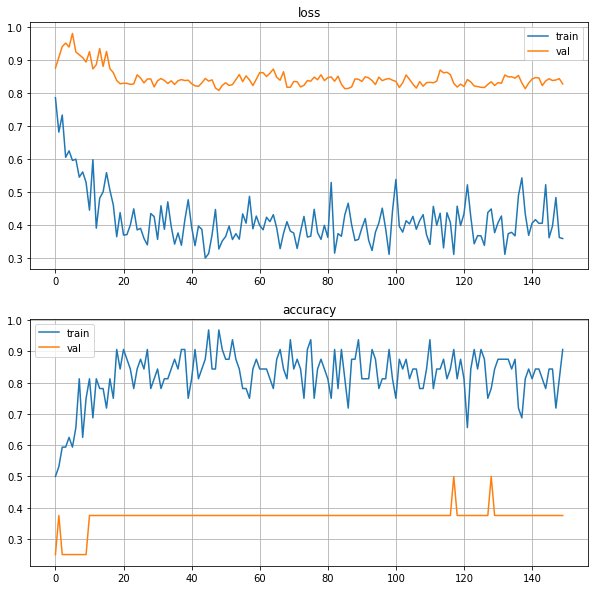

In [9]:
train_model(model, loss, optimizer, scheduler, num_epochs=150);

In [10]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [11]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [12]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:03<00:00, 25.45it/s]


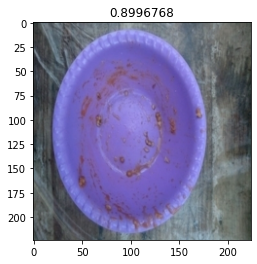

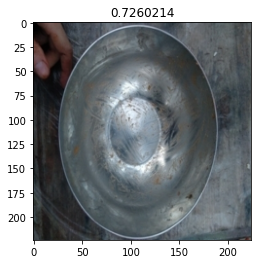

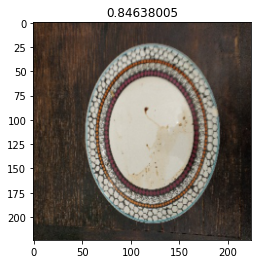

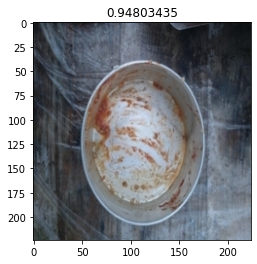

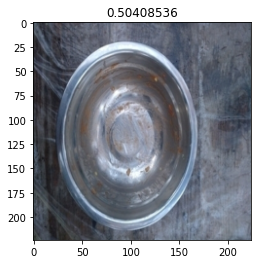

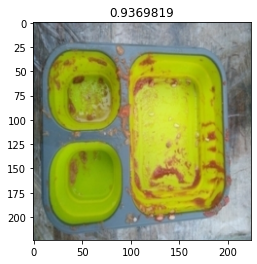

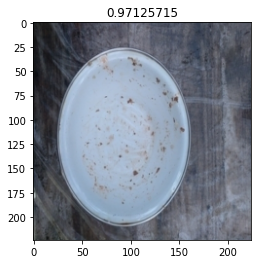

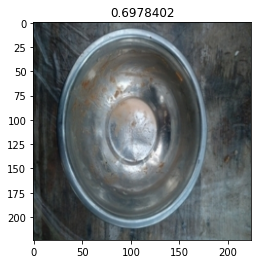

In [13]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [14]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.6 else 'cleaned')   
#submission_df.head()

file_name = 'submission.csv'
submission_df.to_csv(file_name)

#FileLink(file_name)

In [15]:
!rm -rf train val test